In [1]:
import sys
import os

# Add repo root to Python path (one level up from examples/)
sys.path.append(os.path.abspath(".."))  

from src.parsing import *
from src.inference import *
from src.mcmc import *
from CRN_Simulation.CRN import CRN

import numpy as np
import random

In [2]:
# Potentially make something that would generate all the complexes and such.
# Could generalize more.

# Define species names
species_names = ["X", "Y", "Z"]

# Define complexes (example: bi-molecular); Dimension is # species x # complexes
complexes = np.array([
    [0, 1, 0, 0, 2, 0, 0, 1, 1, 0],
    [0, 0, 1, 0, 0, 2, 0, 1, 0, 1],
    [0, 0, 0, 1, 0, 0, 2, 0, 1, 1]
])


# Create Reactant, Product, Stochiometric Matrix, Define Compatible Reactions and Everything Needed for CRN
reactant_matrix, product_matrix, stoichiometric_matrix, reaction_names, parameter_names, unique_changes, compatible_reactions = generate_reactions(complexes, species_names)

# Plot some output to the screen
print(f"Total reactions generated: {len(reaction_names)}")
max_show = 3
print("Some Reaction Names:", reaction_names[:max_show])

print("\nStoichiometric Changes (Grouped by Unique ΔX):")
print("------------------------------------------------")

count_shown = 0

for deltaX in unique_changes:            # <-- ordered, stable, consistent
    rxn_indices = compatible_reactions[deltaX]
    deltaX_clean = tuple(int(x) for x in deltaX)

    # Only show groups with >1 reaction if desired
    # Remove this if you want *all* ΔX shown
    if len(rxn_indices) <= 1:
        continue

    # Collect human-readable reaction names
    rxn_names = [reaction_names[i] for i in rxn_indices]

    print(f"ΔX = {deltaX_clean}")
    print(f"  Reaction indices: {rxn_indices}")
    print("  Reactions:")
    for idx, rname in zip(rxn_indices, rxn_names):
        print(f"    {idx}: {rname}")
    print()

    count_shown += 1
    if count_shown >= max_show:
        break

Total reactions generated: 90
Some Reaction Names: ['Empty_to_X:', 'Empty_to_Y:', 'Empty_to_Z:']

Stoichiometric Changes (Grouped by Unique ΔX):
------------------------------------------------
ΔX = (1, 0, 0)
  Reaction indices: [0, 12, 24, 34]
  Reactions:
    0: Empty_to_X:
    12: X_to_2X:
    24: Y_to_X+Y:
    34: Z_to_X+Z:

ΔX = (0, 1, 0)
  Reaction indices: [1, 15, 22, 35]
  Reactions:
    1: Empty_to_Y:
    15: X_to_X+Y:
    22: Y_to_2Y:
    35: Z_to_Y+Z:

ΔX = (0, 0, 1)
  Reaction indices: [2, 16, 26, 32]
  Reactions:
    2: Empty_to_Z:
    16: X_to_X+Z:
    26: Y_to_Y+Z:
    32: Z_to_2Z:



In [3]:
# Number of Reactino to Sample and Gamma Prior
N = 20
alpha, beta = 2.6, 0.4

# Build CRN Required components by Sampling
(CRN_stoichiometric_matrix, CRN_reaction_names, CRN_parameter_names,
 CRN_propensities, trueTheta, parameter_values, sampled_indices) = build_CRN_bySamplingReactions(
    reactant_matrix, product_matrix, stoichiometric_matrix,
    reaction_names, parameter_names,
    species_names=species_names,
    N=N, alpha=alpha, beta=beta, seed=42, verbose = True)

# Create Reaction Network with CRN_Simulation.CRN
reactionNetwork = CRN(species_names=species_names,
         stoichiometric_matrix=CRN_stoichiometric_matrix,
         parameters_names=CRN_parameter_names,
         reaction_names=CRN_reaction_names,
         propensities=CRN_propensities)


Sampling 20 reactions out of 90 total reactions in the CRN.

Index Param  Reaction Name             Value   
--------------------------------------------------
81    k81    Y+Z_to_Empty:             1.240   
14    k14    X_to_2Z:                  0.826   
3     k3     Empty_to_2X:              0.773   
35    k35    Z_to_Y+Z:                 0.773   
31    k31    Z_to_2Y:                  2.229   
28    k28    Z_to_X:                   1.452   
17    k17    X_to_Y+Z:                 0.652   
13    k13    X_to_2Y:                  1.274   
86    k86    Y+Z_to_2Y:                1.060   
69    k69    X+Y_to_2Z:                0.174   
11    k11    X_to_Z:                   0.423   
75    k75    X+Z_to_Z:                 1.109   
54    k54    2Z_to_Empty:              2.107   
4     k4     Empty_to_2Y:              0.777   
27    k27    Z_to_Empty:               0.617   
29    k29    Z_to_Y:                   0.975   
64    k64    X+Y_to_X:                 0.591   
77    k77    X+Z_to_2Y:

Initial state: {'X': 5, 'Y': 5, 'Z': 5}
Trajectory saved to ../data/example3_trajectory.json


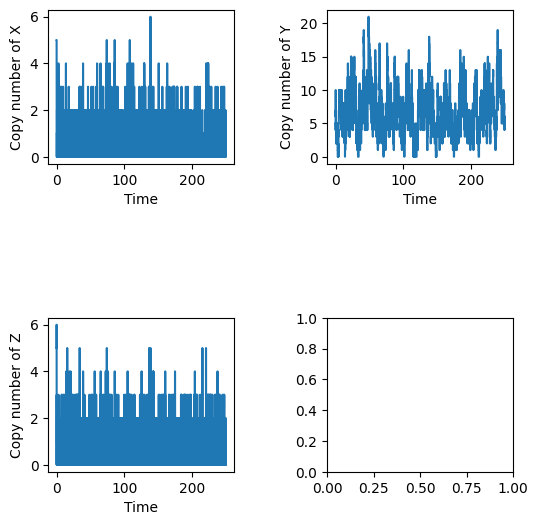

In [4]:
data_dir = "../data"  # relative to examples/ folder
os.makedirs(data_dir, exist_ok=True)

# Generate trajectory
time_list, state_list = generate_single_trajectory(
    reactionNetwork,
    parameter_values,
    species_names,
    finalTime=250,   # adjust as needed
    minVal=5,
    maxVal=5,
    seed=42          # for reproducibility
)

# Save trajectory to JSON
trajectory_file = os.path.join(data_dir, "example3_trajectory.json")
save_trajectory(time_list, state_list, filename=trajectory_file)

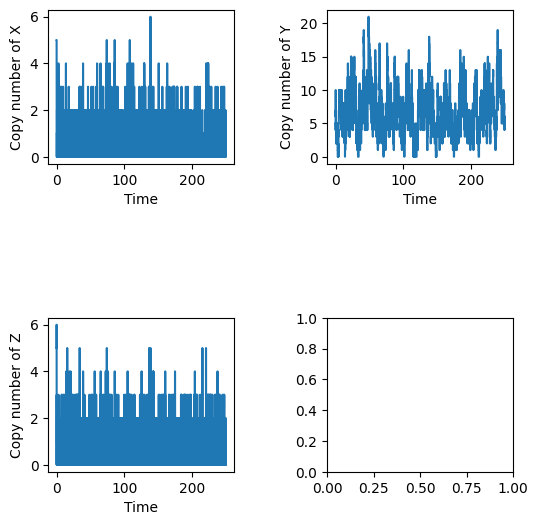

In [5]:
trajectory_file_new = "../data/example3_trajectory.json"
time_list_new, state_list_new = load_trajectory(trajectory_file_new)
reactionNetwork.plot_trajectories(time_list, state_list)

In [6]:
# Parse trajectories for CRN1
print("Parsing Trajectory 1")
unique_states, jump_counts, waiting_times, propensities = parse_trajectory(
    state_list,time_list,reactant_matrix,unique_changes,compatible_reactions,verbose=True)
print("---------")

# Parse trajectories for CRN1
print("Parsing Trajectory 2")
unique_states_new, jump_counts_new, waiting_times_new, propensities_new = parse_trajectory(
    state_list_new,time_list_new,reactant_matrix,unique_changes,compatible_reactions,verbose=True)
print("---------")

# Print basic summary
print("Finished parsing trajectories. Summary:")
print(f"Trajectory 1: {len(unique_states)} unique states observed")
print(f"Trajectory 2: {len(unique_states_new)} unique states observed")

Parsing Trajectory 1
Tracking 54 unique stoichiometric changes.
Trajectory length: 4507 timepoints. Iterating to len-2 to avoid final non-jump.
Finished parsing trajectory. Observed 342 unique states.
---------
Parsing Trajectory 2
Tracking 54 unique stoichiometric changes.
Trajectory length: 4507 timepoints. Iterating to len-2 to avoid final non-jump.
Finished parsing trajectory. Observed 342 unique states.
---------
Finished parsing trajectories. Summary:
Trajectory 1: 342 unique states observed
Trajectory 2: 342 unique states observed


We have 18 distinct stochiometric changes.
Index we are Checking 3
Delta X we are checking (2, 0, 0)
Extracting local data for stoichiometric change [2, 0, 0] at index 3
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 342 states processed.
The Local Theta is [0.77283931]
Total observed jumps for this local stoichiometric change: 194
Local True Theta = [0.77283931]
Log-Likelihood at True Theta = -243.0850144652135
Maximum Log-Likelihood = -243.0830905266217
Best Multiplier = 1.006122448979592
Best Theta = [0.77757097]


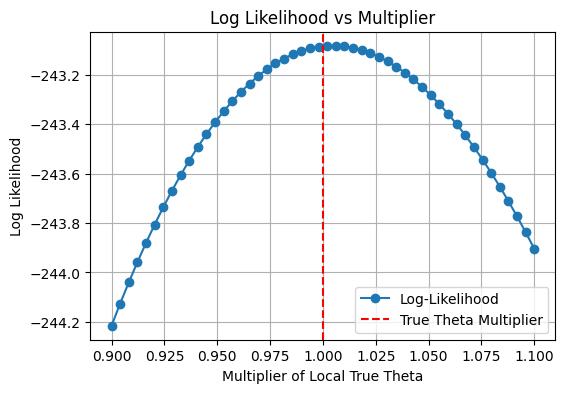

In [7]:
# Local Likelihood Exploration for Network

pos_indices, pos_deltaX = get_positive_deltaX_indices_and_values(jump_counts, unique_changes, verbose=False)

print(f"We have {len(pos_indices)} distinct stochiometric changes.")

i = 1

indexToCheck = pos_indices[i]
deltaXToCheck = pos_deltaX[i]

print(f"Index we are Checking {pos_indices[i]}")
print(f"Delta X we are checking {deltaXToCheck}")

#Extract the local data for the desired stochiometric change.
(local_counts, local_waiting_times, local_propensities, selected_deltaX) = extract_local_data(
    jump_counts, waiting_times, propensities, unique_changes, 
    index=indexToCheck, deltaX=deltaXToCheck, verbose=True)

#Extract the Local True Theta for the unique stochiometric change
localTheta = trueTheta[compatible_reactions[selected_deltaX]]

print(f"The Local Theta is {localTheta}")

multipliers, ll_values, max_ll, best_multiplier, best_theta = plot_likelihood_vs_theta_multiplier(
    local_counts,
    local_waiting_times,
    local_propensities,
    localTheta,
    delta=.1,
    num_points=50,
    title='Log Likelihood vs Multiplier'
)

In [8]:
# Ensure the results directory exists
results_dir = "../results/example3"
os.makedirs(results_dir, exist_ok=True)

## Debugging Parameters
runOnlyHigherDim        = False   # Only try to run cases that have >=2 variables
runOnlyOneHigherDimCase = False  # Only run one case with >=2 variables for debugging

## MCMC parameters
NIterates = 500_000
Burnin    = 50_000
Thinout   = 100

# Loop over all unique stoichiometric changes
for index, deltaX in enumerate(unique_changes):
    
    print(f"\nProcessing Index: {index}, Stoichiometric Change: {deltaX}")

    # Extract local data for this stoichiometric change
    (local_counts, local_waiting_times, local_propensities, selected_deltaX) = extract_local_data(
        jump_counts, waiting_times, propensities, unique_changes, 
        index=index, deltaX=deltaX, verbose=True
    )

    # Extract local true theta
    localTheta = trueTheta[compatible_reactions[selected_deltaX]]
    num_reactions = len(localTheta)

    # Skip low-dimensional cases if debugging
    if num_reactions < 2 and runOnlyHigherDim:
        print(f"🚫 Index {index} skipped: only {num_reactions} reaction(s) — needs at least 2 to run MCMC.")
        continue

    # Compute 2-norm
    norm_theta = np.linalg.norm(localTheta, ord=2)
    print(f"Local True Theta: {localTheta} (Norm: {norm_theta:.4f})")

    # Compute likelihood for true theta
    likeTrue = local_log_likelihood(local_counts, local_waiting_times, local_propensities, localTheta)
    print(f"True Likelihood = {likeTrue}")

    total_count = sum(local_counts.values())
    print(f"Total Count = {total_count}")

    # Initialize theta for MCMC
    a, b = 0.001, 2.0
    theta_init = np.random.uniform(a, b, size=localTheta.shape)
    likeInit = local_log_likelihood(local_counts, local_waiting_times, local_propensities, theta_init)

    # Run adaptive MCMC only if norm is significant
    if norm_theta > 0.01:
        print(f"Running Adaptive MCMC with spike-and-slab prior...")
        
        filtered_reactions = [reaction_names[i] for i in compatible_reactions[selected_deltaX]]
        print(f"Reaction Names = {filtered_reactions}")

        AdaptiveThetaChain = adaptive_mcmc_spike_slab(
            local_counts, local_waiting_times, local_propensities,
            theta_init, trueTheta, num_iterations=NIterates,
            alpha=2, beta=0.25, pi=0.75, burn_in=Burnin, adapt_every_n=10
        )

        # Define filenames
        filenameKDE = os.path.join(results_dir, f"AdaptiveMCMC_plot_Index_{index}_TotalCount_{total_count}_kde.png")
        filenameChain = os.path.join(results_dir, f"AdaptiveMCMC_plot_Index_{index}_TotalCount_{total_count}_chain.png")
        filenamePosterior = os.path.join(results_dir, f"AdaptiveMCMC_plot_Index_{index}_TotalCount_{total_count}_posterior.png")

        # Plotting
        plot_mcmc_samples(AdaptiveThetaChain, localTheta, epsilon=1e-5, burnin=Burnin, thinout=Thinout, filename=filenameKDE)
        plot_mcmc_chain(AdaptiveThetaChain, filename=filenameChain)
        if num_reactions >= 2:
            calc_network_posteriors(AdaptiveThetaChain, epsilon=1e-5, prob_cutoff=0.05, burnin=Burnin, thinout=Thinout)
            plot_network_and_parameter_posteriors(AdaptiveThetaChain, localTheta, epsilon=1e-5,
                                                 prob_cutoff=0.05, burnin=Burnin, thinout=Thinout, filename=filenamePosterior)

        # Summary statistics to Excel
        chains = [AdaptiveThetaChain]
        labels = ["Adaptive Spike & Slab"]
        summarize_chains(chains, localTheta, labels,
                         results_dir=results_dir, filename="mcmc_summary.xlsx",
                         burnin=Burnin, thinout=Thinout, alpha_ci=0.05, epsilon=1e-3,
                         run_index=index, count=total_count)

        print(f"MCMC completed for index {index}.")

        if (num_reactions > 1) and runOnlyOneHigherDimCase:
            break

    else:
        print(f"Skipping MCMC for index {index}: norm too small ({norm_theta:.4f}).")

    print("**********")



Processing Index: 0, Stoichiometric Change: (1, 0, 0)
Extracting local data for stoichiometric change [1, 0, 0] at index 0
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 342 states processed.
Local True Theta: [0. 0. 0. 0.] (Norm: 0.0000)
True Likelihood = 0
Total Count = 0
Skipping MCMC for index 0: norm too small (0.0000).
**********

Processing Index: 1, Stoichiometric Change: (0, 1, 0)
Extracting local data for stoichiometric change [0, 1, 0] at index 1
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 342 states processed.
Local True Theta: [0.         0.         0.         0.77284819] (Norm: 0.7728)
True Likelihood = -60.937526152343835
Total Count = 45
Running Adaptive MCMC with spike-and-slab prior...
Reaction Names = ['Empty_to_Y:', 'X_to_X+Y:', 'Y_to_2Y:', 'Z_

/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:26: RuntimeWarning: invalid value encountered in divide
  acf = acf[n-1:] / acf[n-1]
/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:35: RuntimeWarning: invalid value encountered in scalar divide
  z = (np.mean(a) - np.mean(b)) / np.sqrt(np.var(a)/len(a) + np.var(b)/len(b))
/Users/suzannesindi/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Iteration 10000: Accept Rate = 0.284, Theta = [0.93526334]
Iteration 20000: Accept Rate = 0.281, Theta = [0.7594447]
Iteration 30000: Accept Rate = 0.282, Theta = [0.74369008]
Iteration 40000: Accept Rate = 0.283, Theta = [0.70606586]
Iteration 50000: Accept Rate = 0.283, Theta = [0.83871724]
Iteration 60000: Accept Rate = 0.309, Theta = [0.86154506]
Iteration 70000: Accept Rate = 0.329, Theta = [0.73478818]
Iteration 80000: Accept Rate = 0.344, Theta = [0.85462049]
Iteration 90000: Accept Rate = 0.355, Theta = [0.80852794]
Iteration 100000: Accept Rate = 0.364, Theta = [0.79658429]
Iteration 110000: Accept Rate = 0.371, Theta = [0.75058055]
Iteration 120000: Accept Rate = 0.377, Theta = [0.70349059]
Iteration 130000: Accept Rate = 0.382, Theta = [0.72173167]
Iteration 140000: Accept Rate = 0.386, Theta = [0.81977529]
Iteration 150000: Accept Rate = 0.389, Theta = [0.74522205]
Iteration 160000: Accept Rate = 0.393, Theta = [0.73418309]
Iteration 170000: Accept Rate = 0.396, Theta = [0.

/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  ess = n / (1 + 2 * np.sum(acf[1:]))


Run 3 | Adaptive Spike & Slab: L2 error of mean from true theta = 0.01107
Saving summary to: ../results/example3/mcmc_summary.xlsx
Summary saved successfully.
MCMC completed for index 3.
**********

Processing Index: 4, Stoichiometric Change: (0, 2, 0)
Extracting local data for stoichiometric change [0, 2, 0] at index 4
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 342 states processed.
Local True Theta: [0.7773835] (Norm: 0.7774)
True Likelihood = -240.5648145881252
Total Count = 184
Running Adaptive MCMC with spike-and-slab prior...
Reaction Names = ['Empty_to_2Y:']
Iteration 10000: Accept Rate = 0.266, Theta = [0.80605218]
Iteration 20000: Accept Rate = 0.272, Theta = [0.78200279]
Iteration 30000: Accept Rate = 0.272, Theta = [0.8224283]
Iteration 40000: Accept Rate = 0.272, Theta = [0.82903137]
Iteration 50000: Accept Rate = 0.272, Theta = [0.64510302]
Iteration 60000: Ac

/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:26: RuntimeWarning: invalid value encountered in divide
  acf = acf[n-1:] / acf[n-1]
/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:35: RuntimeWarning: invalid value encountered in scalar divide
  z = (np.mean(a) - np.mean(b)) / np.sqrt(np.var(a)/len(a) + np.var(b)/len(b))
/Users/suzannesindi/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Iteration 10000: Accept Rate = 0.314, Theta = [0.34287995 0.         0.87582581 0.        ]
Iteration 20000: Accept Rate = 0.311, Theta = [0.50937739 0.         0.84663761 0.        ]
Iteration 30000: Accept Rate = 0.310, Theta = [0.62299532 0.         0.80496804 0.        ]
Iteration 40000: Accept Rate = 0.311, Theta = [0.42229314 0.         0.85706618 0.        ]
Iteration 50000: Accept Rate = 0.310, Theta = [0.55763487 0.         0.82196307 0.        ]
Iteration 60000: Accept Rate = 0.297, Theta = [0.22307866 0.         0.88976469 0.        ]
Iteration 70000: Accept Rate = 0.282, Theta = [0.29720533 0.         0.91759207 0.        ]
Iteration 80000: Accept Rate = 0.271, Theta = [0.73612309 0.         0.76224786 0.        ]
Iteration 90000: Accept Rate = 0.261, Theta = [0.08673783 0.         0.95866781 0.        ]
Iteration 100000: Accept Rate = 0.253, Theta = [0.48053246 0.         0.88928403 0.        ]
Iteration 110000: Accept Rate = 0.236, Theta = [0.18999083 0.         0.8754047

/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:26: RuntimeWarning: invalid value encountered in divide
  acf = acf[n-1:] / acf[n-1]
/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:35: RuntimeWarning: invalid value encountered in scalar divide
  z = (np.mean(a) - np.mean(b)) / np.sqrt(np.var(a)/len(a) + np.var(b)/len(b))
/Users/suzannesindi/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Iteration 10000: Accept Rate = 0.084, Theta = [0.40256422]
Iteration 20000: Accept Rate = 0.083, Theta = [0.40257173]
Iteration 30000: Accept Rate = 0.083, Theta = [0.41392055]
Iteration 40000: Accept Rate = 0.082, Theta = [0.40147724]
Iteration 50000: Accept Rate = 0.083, Theta = [0.41219385]
Iteration 60000: Accept Rate = 0.126, Theta = [0.39564062]
Iteration 70000: Accept Rate = 0.158, Theta = [0.3808186]
Iteration 80000: Accept Rate = 0.183, Theta = [0.40125762]
Iteration 90000: Accept Rate = 0.203, Theta = [0.42345233]
Iteration 100000: Accept Rate = 0.220, Theta = [0.4448114]
Iteration 110000: Accept Rate = 0.235, Theta = [0.4042145]
Iteration 120000: Accept Rate = 0.247, Theta = [0.41255138]
Iteration 130000: Accept Rate = 0.258, Theta = [0.41238051]
Iteration 140000: Accept Rate = 0.267, Theta = [0.43032365]
Iteration 150000: Accept Rate = 0.275, Theta = [0.42646794]
Iteration 160000: Accept Rate = 0.282, Theta = [0.44634877]
Iteration 170000: Accept Rate = 0.289, Theta = [0.42

/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:26: RuntimeWarning: invalid value encountered in divide
  acf = acf[n-1:] / acf[n-1]
/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:35: RuntimeWarning: invalid value encountered in scalar divide
  z = (np.mean(a) - np.mean(b)) / np.sqrt(np.var(a)/len(a) + np.var(b)/len(b))
/Users/suzannesindi/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Iteration 10000: Accept Rate = 0.684, Theta = [1.50803935 0.         0.         0.        ]
Iteration 20000: Accept Rate = 0.695, Theta = [1.31718919 0.         0.         0.        ]
Iteration 30000: Accept Rate = 0.702, Theta = [1.34988585 0.         0.         0.        ]
Iteration 40000: Accept Rate = 0.706, Theta = [1.28896753 0.         0.         0.        ]
Iteration 50000: Accept Rate = 0.704, Theta = [1.55519084 0.         0.         0.        ]
Iteration 60000: Accept Rate = 0.632, Theta = [1.3409146 0.        0.        0.       ]
Iteration 70000: Accept Rate = 0.577, Theta = [0.98341211 0.         0.         0.        ]
Iteration 80000: Accept Rate = 0.535, Theta = [1.31893067 0.         0.         0.        ]
Iteration 90000: Accept Rate = 0.503, Theta = [1.49865523 0.         0.         0.        ]
Iteration 100000: Accept Rate = 0.476, Theta = [1.31162109 0.         0.         0.        ]
Iteration 110000: Accept Rate = 0.453, Theta = [1.34484544 0.         0.         0.

/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  ess = n / (1 + 2 * np.sum(acf[1:]))
/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:26: RuntimeWarning: invalid value encountered in divide
  acf = acf[n-1:] / acf[n-1]
/Users/suzannesindi/Documents/GitHub/BayesCRNInference/src/mcmc.py:35: RuntimeWarning: invalid value encountered in scalar divide
  z = (np.mean(a) - np.mean(b)) / np.sqrt(np.var(a)/len(a) + np.var(b)/len(b))
/Users/suzannesindi/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


Iteration 10000: Accept Rate = 0.385, Theta = [1.05200026 0.         0.         0.97187213]
Iteration 20000: Accept Rate = 0.393, Theta = [0.83623359 0.         0.         0.94897069]
Iteration 30000: Accept Rate = 0.395, Theta = [1.82493976 0.         0.         0.8700218 ]
Iteration 40000: Accept Rate = 0.397, Theta = [0.68955793 0.         0.         1.01421816]
Iteration 50000: Accept Rate = 0.399, Theta = [1.95424743 0.         0.         0.91229564]
Iteration 60000: Accept Rate = 0.378, Theta = [0.96562177 0.         0.         0.90752705]
Iteration 70000: Accept Rate = 0.361, Theta = [1.04729785 0.         0.         0.93819203]
Iteration 80000: Accept Rate = 0.348, Theta = [1.35257253 0.         0.         0.91401281]
Iteration 90000: Accept Rate = 0.338, Theta = [1.345932   0.         0.         0.91569814]
Iteration 100000: Accept Rate = 0.331, Theta = [0.92220168 0.         0.         1.05847877]
Iteration 110000: Accept Rate = 0.323, Theta = [1.0438242  0.         0.       